In [1]:
from ROOT import TCanvas, TFile
from ROOT import TGraphErrors, TF1
from ROOT import gStyle
from array import array
import math
import numpy as np
import random

c1 = TCanvas( 'c1', 'Non-Linear Fitting Example with Errors', 200, 10, 700, 500 )
c1.SetGridx()
c1.SetGridy()
c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderMode(-1 )
c1.GetFrame().SetBorderSize( 5 )

Welcome to JupyROOT 6.18/00


In [2]:
def fitfunction(x,par):
    return par[0]*x/(par[1]+x)

def fitfunction_root(x,par):
    return par[0]*x[0]/(par[1]+x[0])

In [3]:
def jacobian_beta1(x,par):
    return -x/(par[1]+x)

In [4]:
def jacobian_beta2(x,par):
    return par[0]*x/((par[1]+x)*(par[1]+x))

In [5]:
gStyle.SetOptFit(1)

par_actual = array('d')
par_actual.append(0.3797)
par_actual.append(0.5111)

beta_order = 2 #Set the order of the polynomial
m = 7 #Set the number of data points
x = array('d')
y = array('d')
ex = array('d')
ey = array('d')

x.append(0.038)
x.append(0.194)
x.append(0.425)
x.append(0.626)
x.append(1.253)
x.append(2.500)
x.append(3.740)

In [6]:
random.seed(1)

for i in range(0,m):
    r = random.gauss(0.0,0.005)
    y.append(fitfunction(x[i],par_actual)+r)
    ex.append(0)
    ey.append(0.005)

In [7]:
n = beta_order

Jacobian = np.zeros(shape = (m,n))
Jacobian2 = np.zeros(shape = (m,n))
JacobianT = np.zeros(shape = (n,m))
Weights = np.zeros(shape = (m,m))
JTW = np.zeros(shape = (n,m))
WJ = np.zeros(shape = (m,n))
residuals = np.zeros(shape = (m,1))
JTWr = np.zeros(shape = (n,1))
JTWJ = np.zeros(shape = (n,n))
JTWJInv = np.zeros(shape = (n,n))

betas = np.zeros(shape = (n,1))
Delta = np.zeros(shape = (n,1))

In [8]:
betas[0][0] = 0.90
betas[1][0] = 0.20

parameter_matrix = array('d')
parameter_matrix_dbeta = array('d')
parameter_matrix.append(betas[0][0])
parameter_matrix.append(betas[1][0])
parameter_matrix_dbeta.append(betas[0][0])
parameter_matrix_dbeta.append(betas[1][0])

dbetamax = 10000
dbeta = 0
epsilon = 0.000001
epsilon_beta = 0.005

jacobian_flag = 1

In [9]:
while (dbetamax > epsilon):
    for i in range(0,m):
        function_value = fitfunction(x[i],parameter_matrix)
        residuals[i][0]=y[i]-function_value
        
        for k in range(0,m):
            if (i==k):
                Weights[i][k]=1.0/(ey[i]*ey[i])
            else:
                Weights[i][k]=0.0
                
        if (jacobian_flag == 1):
            for j in range(0,n):
                for k in range(0,n):
                    if (k==j):
                        parameter_matrix_dbeta[k]=parameter_matrix[k]+epsilon_beta
                    else:
                        parameter_matrix_dbeta[k]=parameter_matrix[k]
                f0 = fitfunction(x[i],parameter_matrix)
                f1 = fitfunction(x[i],parameter_matrix_dbeta)
                jacobian = (f0-f1)/epsilon_beta
                Jacobian[i][j]=jacobian
                #print(i,j,jacobian)
                #print(parameter_matrix[0],parameter_matrix_dbeta[0])
                #print(parameter_matrix[1],parameter_matrix_dbeta[1])
                #print(f0,f1)    
        else:
            for j in range(0,n):
                if (j==0):
                    jacobian = jacobian_beta1(x[i],parameter_matrix)
                else:
                    jacobian = jacobian_beta2(x[i],parameter_matrix)
                Jacobian[i][j]=jacobian
                #print(i,j,jacobian)
            
    JacobianT = Jacobian.transpose()
    JTW = np.array(np.matrix(JacobianT)*np.matrix(Weights))
    JTWr = np.array(np.matrix(JTW)*np.matrix(residuals))
    WJ = np.array(np.matrix(Weights)*np.matrix(Jacobian))
    JTWJ = np.array(np.matrix(JacobianT)*np.matrix(WJ))
    JTWJInv = np.array(np.linalg.inv(JTWJ))
    Delta = np.array(np.matrix(JTWJInv)*np.matrix(JTWr))

    dbetamax = 0.0
    
    for j in range(0,n):
        parameter_matrix[j]=parameter_matrix[j]-Delta[j][0]
        dbeta = math.fabs(Delta[j][0]/parameter_matrix[j])
        if (dbeta > dbetamax): 
            dbetamax = dbeta
        #print ("dbetamax = %f" % dbetamax )

In [10]:
print(Jacobian)
print(" ")

print(JacobianT)
print(" ")

print(JTWr)
print(" ")

print(JTWJ)
print(" ")

print(JTWJInv)
print(" ")


[[-0.07288012  0.05141082]
 [-0.28638737  0.1558393 ]
 [-0.46785342  0.19020048]
 [-0.56426685  0.18802111]
 [-0.72160619  0.15387408]
 [-0.83796893  0.10412461]
 [-0.88554158  0.07776734]]
 
[[-0.07288012 -0.28638737 -0.46785342 -0.56426685 -0.72160619 -0.83796893
  -0.88554158]
 [ 0.05141082  0.1558393   0.19020048  0.18802111  0.15387408  0.10412461
   0.07776734]]
 
[[-0.00048757]
 [-0.00017548]]
 
[[105268.17817261 -20424.52611625]
 [-20424.52611625   5560.96192737]]
 
[[3.30555000e-05 1.21407579e-04]
 [1.21407579e-04 6.25735674e-04]]
 


In [11]:
error_sum = 0
yfit = 0
error = array('d')

for j in range(0,m):
    yfit = fitfunction(x[j],parameter_matrix)
    print ("i x y fit = %d %f %f %f " % (j,x[j],y[j],yfit))
    error_sum = error_sum + (yfit-y[j])*(yfit-y[j])/(ey[j]*ey[j])
    yfit = 0

print (" ")
    
chi2 = error_sum/(m-n)
print ("chi2/dof = %f / %f" % (error_sum,(m-n)))

for k in range(0,n):
        error.append(math.sqrt(JTWJInv[k][k]))
        print(" beta[%d] = %f +/- %f" % ((k+1),parameter_matrix[k],error[k]))


i x y fit = 0 0.038000 0.032718 0.027063 
i x y fit = 1 0.194000 0.111717 0.106345 
i x y fit = 2 0.425000 0.172720 0.173730 
i x y fit = 3 0.626000 0.205211 0.209531 
i x y fit = 4 1.253000 0.264231 0.267957 
i x y fit = 5 2.500000 0.315407 0.311166 
i x y fit = 6 3.740000 0.328939 0.328832 
 
chi2/dof = 4.495800 / 5.000000
 beta[1] = 0.371334 +/- 0.005749
 beta[2] = 0.483404 +/- 0.025015


In [12]:
gr = TGraphErrors(m,x,y,ex,ey)
pfit1 = TF1("fitfunction",fitfunction_root,0.0,4.0,2)
pfit1.SetParameters(0.30,0.75)
pfit1.SetParNames("Vmax","Km")
gr.SetMarkerStyle(21)
gr.SetTitle("Non-Linear Fit")
gr.GetXaxis().SetTitle("[S]")
gr.GetYaxis().SetTitle("Rate")
gr.Fit("fitfunction","V")
pfit1chi2 = pfit1.GetChisquare()
pfit1ndf = pfit1.GetNDF()
pfit1chi2ndf = pfit1chi2/pfit1ndf
print("Fit 1: %f %f \n" % (pfit1chi2,pfit1ndf))
gr.Draw("AP")

Fit 1: 4.495788 5.000000 

 **********
 **    1 **SET PRINT           2
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 Vmax         3.00000e-01  9.00000e-02     no limits
     2 Km           7.50000e-01  2.25000e-01     no limits
 **********
 **    3 **SET ERR           1
 **********
 **********
 **    4 **SET PRINT           2
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1220        0.01
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-05
 FCN=201.846 FROM MIGRAD    STATUS=INITIATE       21 CALLS          22 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.

Info in <TMinuitMinimizer::Minimize>: Finished to run MIGRAD - status 0


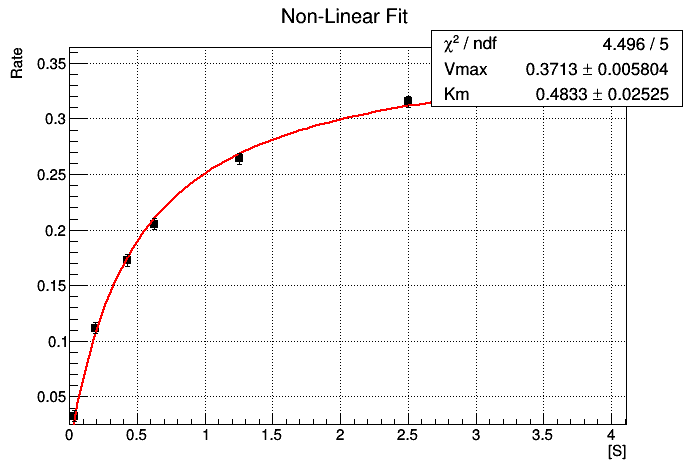

In [13]:
c1.Draw()

In [14]:
c2 = TCanvas( 'c2', 'S^2 Histogram', 200, 10, 700, 500 )
c2.SetGridx()
c2.SetGridy()
c2.GetFrame().SetFillColor( 21 )
c2.GetFrame().SetBorderMode(-1 )
c2.GetFrame().SetBorderSize( 5 )

In [15]:
nbins = 101
xwidth = 0.2000
ywidth = 0.5000
xlow = parameter_matrix[0]-xwidth/2.0
xhigh = parameter_matrix[0]+xwidth/2.0
ylow = parameter_matrix[1]-ywidth/2.0
yhigh = parameter_matrix[1]+ywidth/2.0

In [16]:
from ROOT import TH2D
h2 = TH2D("h2","S^2 Histogram",nbins,xlow,xhigh,nbins,ylow,yhigh)

In [17]:
b1 = array('d')
b2 = array('d')
pars = array('d')
pars.append(0)
pars.append(0)
for j in range(0,nbins):
    b1.append(0)
    b2.append(0)
    
for j in range(0,nbins):
    pars[0]=(parameter_matrix[0]+(j-(nbins-1.0)/2.0)/(nbins-1)*xwidth)
    b1[j]=pars[0]
    for k in range(0,nbins):
        pars[1]=(parameter_matrix[1]+(k-(nbins-1.0)/2.0)/(nbins-1)*ywidth)
        b2[k]=pars[1]
        sum = 0
        for i in range(0,m):
            yfit = fitfunction(x[i],pars)
            sum = sum + (yfit-y[i])*(yfit-y[i])/(ey[i]*ey[i])
        h2.Fill(b1[j],b2[k],sum)

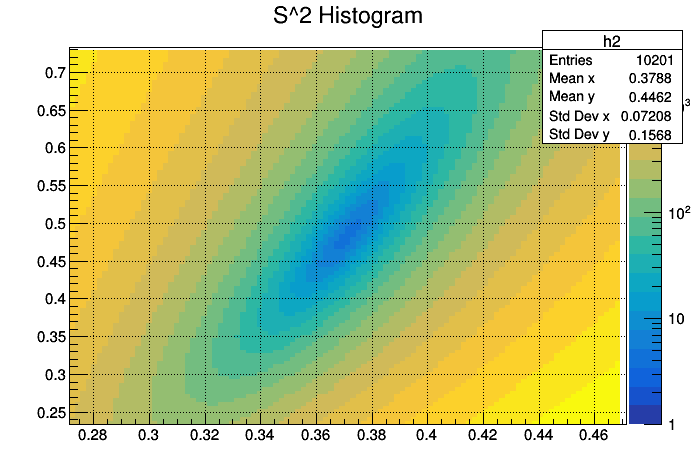

In [18]:
c2.SetLogz()
h2.Draw("COLZ")
c2.Draw()
